# TensorFlow Time Series Predictions

Play with the same data as linear regressions.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import util

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
# Number of days to generate data for
DAYS = 50

df = None
for d in range(0, DAYS):
    print('Day %d' % d)
    if df is not None:
        df = df.append(util.gen_random_data_frame(first_index=d*1440), ignore_index=True)
    else:
        df = util.gen_random_data_frame(first_index=d*1440)
df

Day 0
Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Day 8
Day 9
Day 10
Day 11
Day 12
Day 13
Day 14
Day 15
Day 16
Day 17
Day 18
Day 19
Day 20
Day 21
Day 22
Day 23
Day 24
Day 25
Day 26
Day 27
Day 28
Day 29
Day 30
Day 31
Day 32
Day 33
Day 34
Day 35
Day 36
Day 37
Day 38
Day 39
Day 40
Day 41
Day 42
Day 43
Day 44
Day 45
Day 46
Day 47
Day 48
Day 49


,Time,Security ACEs
0,0,100
1,1,100
2,2,100
3,3,101
4,4,100
...,...,...
71995,71995,100
71996,71996,100
71997,71997,100
71998,71998,101


In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    '''
    * history_size size of past window of information
    * target_size how far in the future to predict
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1107be510>],
      dtype=object)

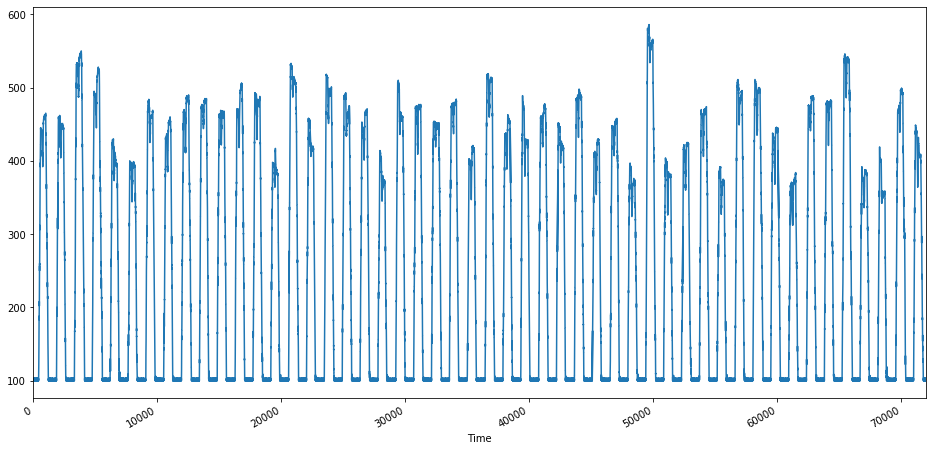

In [4]:
uni_data = df['Security ACEs']
uni_data.index = df['Time']
uni_data.plot(subplots=True)

## Normalize Data

Mean    = 244.30429166666667
Std Dev = 159.83167197769006


array([<matplotlib.axes._subplots.AxesSubplot object at 0x144a1b7d0>],
      dtype=object)

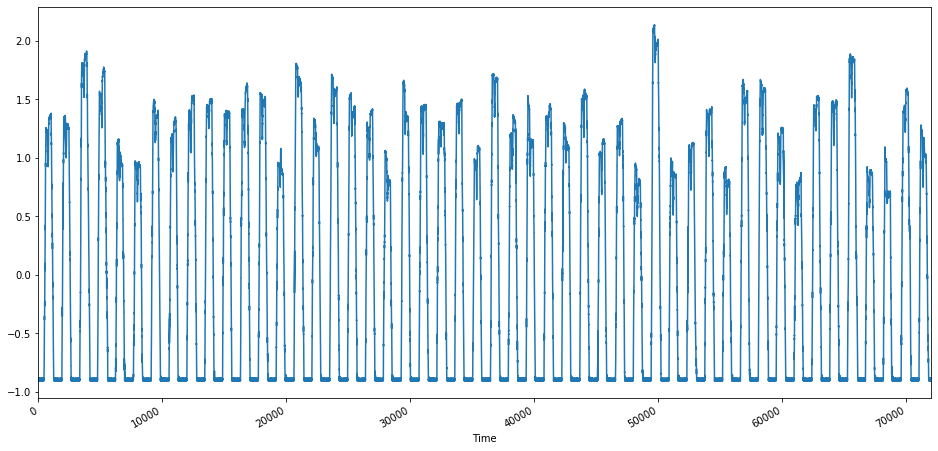

In [5]:
uni_train_mean = uni_data.mean()
uni_train_std = uni_data.std()

print('Mean    = {}'.format(uni_train_mean))
print('Std Dev = {}'.format(uni_train_std))

uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data.plot(subplots=True)

## Prepare Data

In [6]:
uni_data_vals = uni_data.values

univariate_past_history = 1440
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data_vals, 0, 1440*(DAYS-2),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_vals, 1440*(DAYS-2), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [9]:
print(x_train_uni.shape)
#print(x_train_uni)
print(y_train_uni.shape)
#print(y_train_uni)

(67680, 1440, 1)
(67680,)


In [20]:
x_train_uni[67679][0]

array([-0.89659509])

In [8]:
def create_time_steps(length):
    return list(range(-length, 0))

In [9]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'gx', 'ro']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/einarnn/.virtualenvs/a/lib/python3.7/site-packages/matplotlib/pyplot.py'>

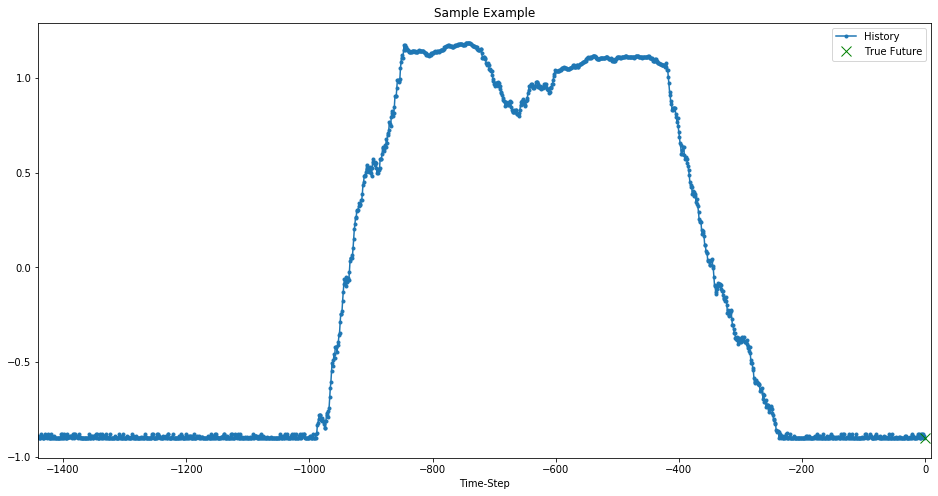

In [11]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Take Average of Last Day of Observations & Predict

In [12]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/einarnn/.virtualenvs/a/lib/python3.7/site-packages/matplotlib/pyplot.py'>

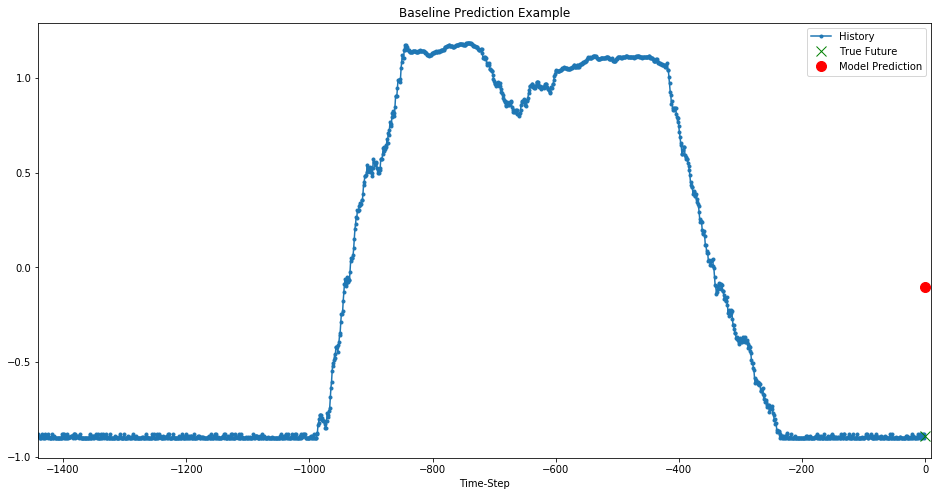

In [13]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

This is really not a very good prediction mechanism!!

## Recurrent Neural Network

In [14]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(139680, 1440, 1)
(139680,)


In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [16]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [17]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [18]:
EVALUATION_INTERVAL = 200  # original 200
VALIDATION_STEPS = 50      # original 50
EPOCHS = 5

simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 124s 619ms/step - loss: 0.4105 - val_loss: 0.0666
Epoch 2/5
200/200 [==============================] - 118s 591ms/step - loss: 0.0551 - val_loss: 0.0180
Epoch 3/5
200/200 [==============================] - 124s 619ms/step - loss: 0.0184 - val_loss: 0.0160
Epoch 4/5
200/200 [==============================] - 118s 588ms/step - loss: 0.0163 - val_loss: 0.0146
Epoch 5/5
200/200 [==============================] - 115s 573ms/step - loss: 0.0153 - val_loss: 0.0132


In [20]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for x, y in val_univariate.take(5):
    print(x)
    print(y)
    print('-'*20)
    #print(x[0].numpy().shape)
    #print(y[0].numpy())
    #print(simple_lstm_model.predict(x)[0])
    #print(simple_lstm_model.predict(x))

(1440, 1)
()


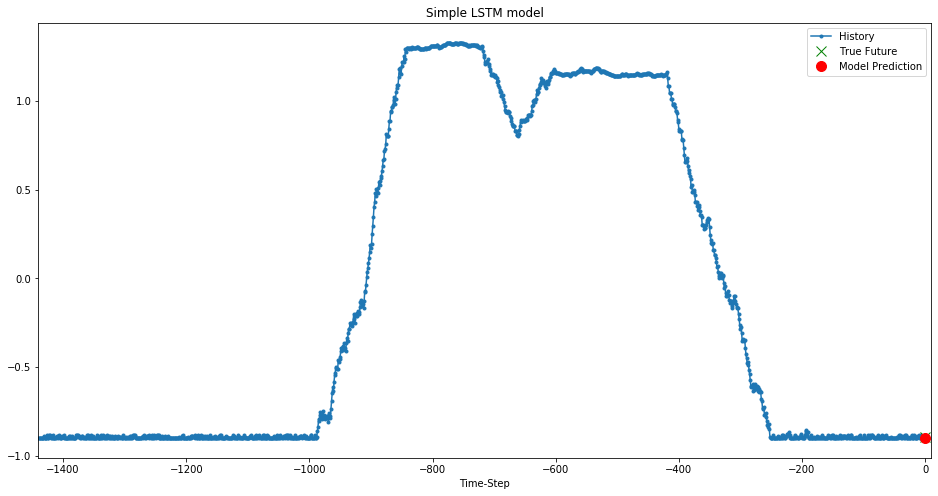

(1440, 1)
()


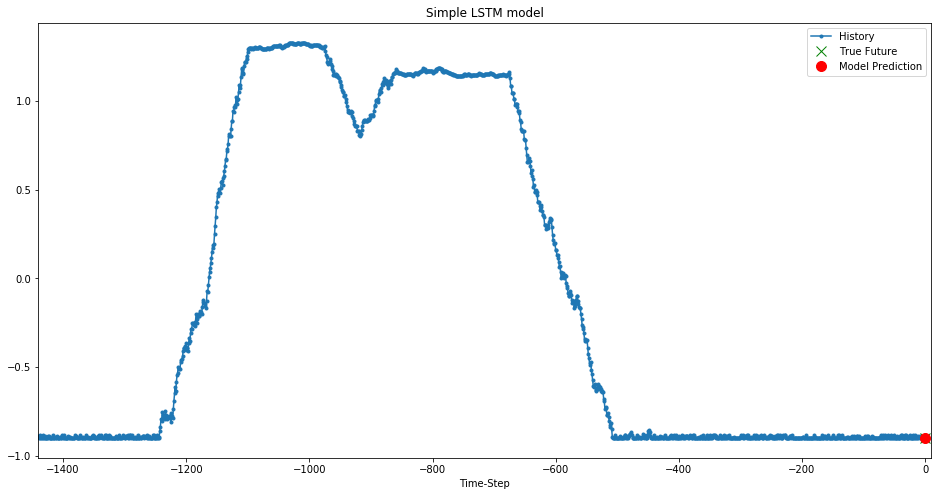

(1440, 1)
()


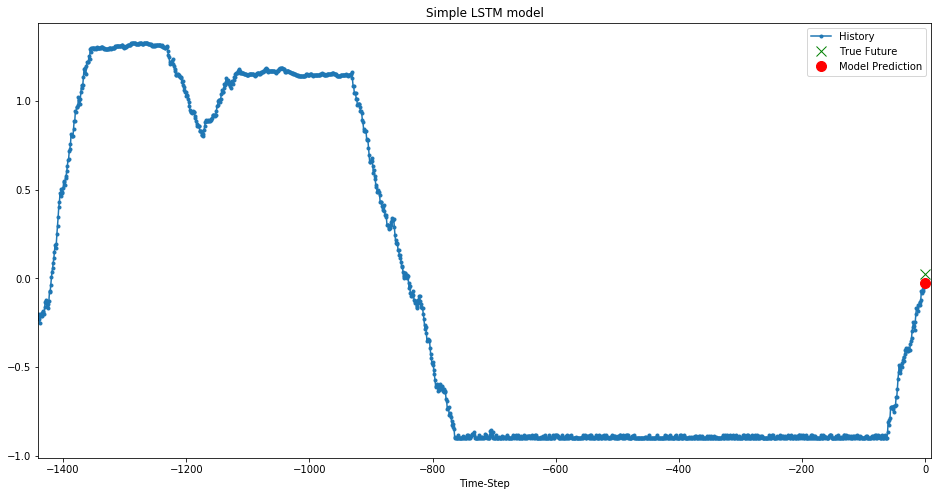

(1440, 1)
()


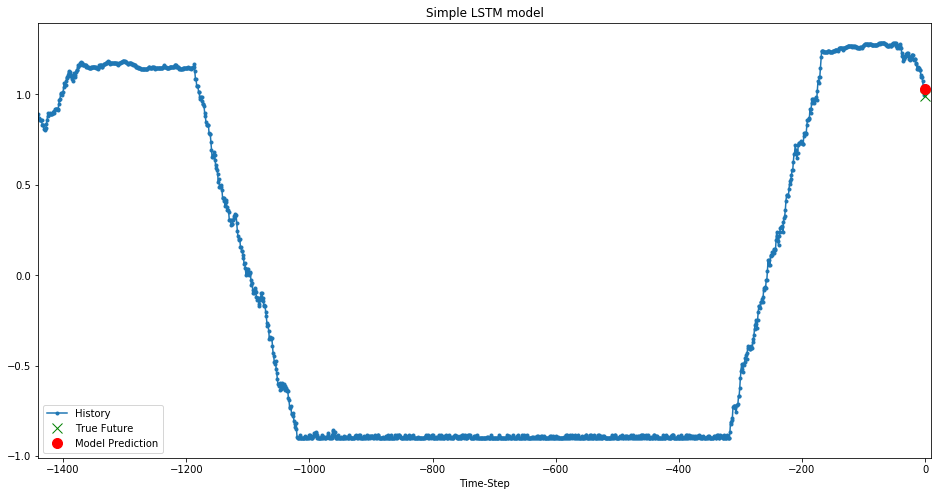

(1440, 1)
()


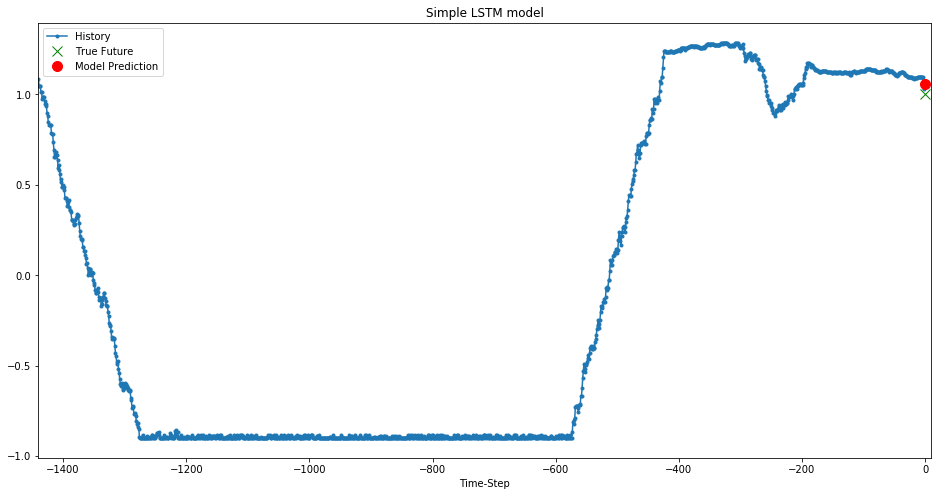

In [21]:
for x, y in val_univariate.take(10):
    print(x[0].numpy().shape)
    print(y[0].numpy().shape)
    #print(simple_lstm_model.predict(x)[0])
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# Scratch Area

In [ ]:
dataset = df
start_index = 0
end_index = 1440 * 3
history_size = 1440
target_size = 0

data = []
labels = []

start_index = start_index + history_size
if end_index is None:
    end_index = len(dataset) - target_size

for i in range(start_index, end_index):
    print('i', i)
    indices = range(i-history_size, i)
    print('indices', indices)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])

np.array(data), np.array(labels)

In [ ]:
dataset['Time']